/tmp/ipykernel_38622/2598252457.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


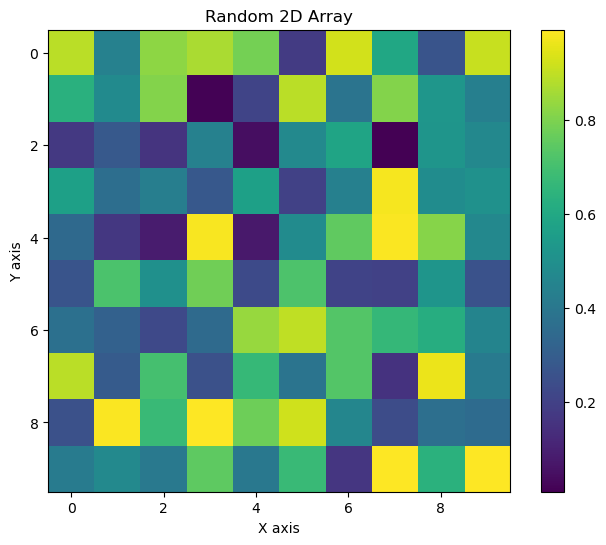

In [1]:
import sys
import os
import argparse
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

import modules.spikingjelly;
from modules.spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from modules.spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from modules.spikingjelly.datasets.n_mnist import NMNIST
# from modules.spikingjelly.datasets.es_imagenet import ESImageNet
from modules.spikingjelly.datasets import split_to_train_test_set
from modules.spikingjelly.datasets.n_caltech101 import NCaltech101
from modules.spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import modules.torchneuromorphic as torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz
from turtle import shape



from scipy import io
from collections import Counter
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import math
from torch.utils.data import TensorDataset

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [3]:
def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

### Neuropixels_choi 상태 함 보자

In [4]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/set1", "/set2/set2", "/set3/set3", "/set4/set4"]

In [5]:
index = 0 # 0-->set1, 1-->set2, 2-->set3, 3-->set4
n_unit = 7 if index != 2 else 8 # set2는 예외적으로 unit 8개다.

# method = 'mean'
# method = 'grad_offset'
method = 'neo_offset'

spike_class = f"{data_path}{filename[index]}_class_{method}.csv"
spike_raw = f"{data_path}{filename[index]}_waveform_{method}.csv"

In [6]:
# Class 파일 로드 (한 열로 저장된 값들)
with open(spike_class, "r") as f:
    class_data = np.array([int(line.strip()) for line in f])[1:]

# Waveform 파일 로드 (반점으로 구분된 행렬 형태)
waveform_data = np.loadtxt(spike_raw, delimiter=",", dtype=np.int16).T

In [7]:
print(f"{'Property':<20} | {'Value'}")
print("-" * 40)
print(f"{'Waveform Data Type':<20} | {waveform_data.dtype}")
print(f"{'Waveform Data Shape':<20} | {waveform_data.shape}")
print(f"{'Class Data Shape':<20} | {class_data.shape}")

Property             | Value
----------------------------------------
Waveform Data Type   | int16
Waveform Data Shape  | (77151, 141)
Class Data Shape     | (77151,)


In [8]:
training_spike_group_reshape = waveform_data
spike_length = waveform_data.shape[1]
training_spike_group_label_reshape = class_data.reshape(-1, 1)
print('총 스파이크 개수', training_spike_group_label_reshape.shape)

총 스파이크 개수 (77151, 1)


In [9]:
training_spike_group_reshape.shape

(77151, 141)

In [10]:
# 좀 자르자 70개 너무 많다.
spike_exact = 70 # matlab에서 crop할 때 70의 index가 ground truth timing임.
want_to_look_just_n_sample = 30 # max: 140 # 니가 140개만 뽑았잖아 141개도되나?
training_spike_group_reshape_sliced = training_spike_group_reshape[:, spike_exact - want_to_look_just_n_sample//2:spike_exact - want_to_look_just_n_sample//2 + want_to_look_just_n_sample]

In [11]:
training_spike_group_reshape_sliced.shape

(77151, 30)

## Hyperparameter


In [12]:

what_data = 'quiroga' # 'quiroga' or 'n2016'
n_sample = want_to_look_just_n_sample if what_data == 'n2016' else 50 # 한 스파이크 파형에 몇 개의 샘플? 

if what_data == 'n2016':
    assert want_to_look_just_n_sample == n_sample
if what_data == 'quiroga':
    assert n_sample == 50

In [13]:
class SSBH_DimChanger_for_fc(nn.Module):
    def __init__(self):
        super(SSBH_DimChanger_for_fc, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class SSBH_DimChanger_for_conv1(nn.Module):
    def __init__(self, out_channels):
        super(SSBH_DimChanger_for_conv1, self).__init__()
        self.out_channels = out_channels
    def forward(self, x):
        x = x.view(x.size(0), self.out_channels, -1)
        return x
class SSBH_DimChanger_for_unsuqeeze(nn.Module):
    def __init__(self, dim=1):
        super(SSBH_DimChanger_for_unsuqeeze, self).__init__()
        self.dim = dim

    def forward(self, x):
        x = x.unsqueeze(self.dim)
        return x
class SSBH_DimChanger_for_suqeeze(nn.Module):
    def __init__(self, dim=1):
        super(SSBH_DimChanger_for_suqeeze, self).__init__()
        self.dim = dim
    def forward(self, x):
        x = x.squeeze(self.dim)
        return x
class SSBH_size_detector(nn.Module):
    def __init__(self):
        super(SSBH_size_detector, self).__init__()

    def forward(self, x):
        print(x.size())
        return x
class SSBH_L2NormLayer(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(SSBH_L2NormLayer, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        # return F.normalize(x, p=2, dim=self.dim, eps=self.eps)
        norm = torch.norm(x, p=2, dim=self.dim, keepdim=True)
        x = x / (norm + self.eps)
        return x
    
class SSBH_DimChanger_one_two(nn.Module):
    def __init__(self):
        super(SSBH_DimChanger_one_two, self).__init__()

    def forward(self, x):
        dims = list(range(x.dim()))  # 전체 차원의 인덱스 리스트
        dims[0], dims[1] = dims[1], dims[0]  # 첫 번째와 두 번째 차원 교체
        return x.permute(*dims)
    
class SSBH_DimChanger_for_one_two_coupling(nn.Module):
    def __init__(self, TIME):
        super(SSBH_DimChanger_for_one_two_coupling, self).__init__()
        self.TIME = TIME

    def forward(self, x):
        T, B, *spatial_dims = x.shape
        assert T == self.TIME
        x = x.reshape(T * B, *spatial_dims)
        return x   
class SSBH_DimChanger_for_one_two_decoupling(nn.Module):
    def __init__(self, TIME):
        super(SSBH_DimChanger_for_one_two_decoupling, self).__init__()
        self.TIME = TIME

    def forward(self, x):
        TB, *spatial_dims = x.shape
        T = self.TIME 
        B = TB // T
        assert TB == T*B
        x = x.reshape(T, B, *spatial_dims)
        return x

In [14]:
# Autoencoder 모델 정의
class SAE_fc_only(nn.Module):
    def __init__(self, encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,50], in_channels=1, synapse_fc_trace_const1=1,synapse_fc_trace_const2=0.7, TIME=10, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=False):
        super(SAE_fc_only, self).__init__()
        self.encoder_ch = encoder_ch
        self.decoder_ch = decoder_ch
        self.in_channels = in_channels
        self.synapse_fc_trace_const1 = synapse_fc_trace_const1
        self.synapse_fc_trace_const2 = synapse_fc_trace_const2
        self.TIME = TIME
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.sg_width = sg_width
        self.surrogate = surrogate
        self.BPTT_on = BPTT_on
        self.need_bias = need_bias

        assert self.decoder_ch == self.encoder_ch[:-1][::-1]+[self.in_channels]

        self.encoder = []
        self.decoder = []

        past_channel = self.in_channels

        # self.encoder.append(SSBH_size_detector())
        self.encoder += [SSBH_DimChanger_one_two()]
        # self.encoder.append(SSBH_size_detector())
        for en_i in range(len(self.encoder_ch)):
            # self.encoder += [SSBH_size_detector()]
            self.encoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
            self.encoder += [nn.Linear(past_channel, self.encoder_ch[en_i], bias = self.need_bias)]
            # self.encoder += [SYNAPSE_FC_BPTT(in_features=past_channel,  # 마지막CONV의 OUT_CHANNEL * H * W
            #                 out_features=self.encoder_ch[en_i], 
            #                 trace_const1=self.synapse_fc_trace_const1,  #BPTT에선 안 씀
            #                 trace_const2=self.synapse_fc_trace_const2, #BPTT에선 안 씀
            #                 TIME=self.TIME)]
            self.encoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]
            self.encoder += [LIF_layer(v_init=self.v_init, 
                                            v_decay=self.v_decay, 
                                            v_threshold=self.v_threshold, 
                                            v_reset=self.v_reset, 
                                            sg_width=self.sg_width,
                                            surrogate=self.surrogate,
                                            BPTT_on=self.BPTT_on)]
            # self.encoder.append(SSBH_size_detector())
            past_channel = self.encoder_ch[en_i]
        self.encoder += [SSBH_L2NormLayer()] 
        # self.encoder.append(SSBH_size_detector())

        self.encoder += [SSBH_DimChanger_one_two()]
        self.encoder = nn.Sequential(*self.encoder)


        self.decoder += [SSBH_DimChanger_one_two()]
        # self.decoder.append(SSBH_size_detector())
        for de_i in range(len(self.decoder_ch)):
            # self.decoder += [SSBH_size_detector()]
            self.decoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
            self.decoder += [nn.Linear(past_channel, self.decoder_ch[de_i], bias = self.need_bias)]
            # self.decoder += [SYNAPSE_FC_BPTT(in_features=past_channel,  # 마지막CONV의 OUT_CHANNEL * H * W
            #                 out_features=self.decoder_ch[de_i], 
            #                 trace_const1=self.synapse_fc_trace_const1,  #BPTT에선 안 씀
            #                 trace_const2=self.synapse_fc_trace_const2, #BPTT에선 안 씀
            #                 TIME=self.TIME)]
            self.decoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]
            if de_i != len(self.decoder_ch)-1:
                self.decoder += [LIF_layer(v_init=self.v_init, 
                                                v_decay=self.v_decay, 
                                                v_threshold=self.v_threshold, 
                                                v_reset=self.v_reset, 
                                                sg_width=self.sg_width,
                                                surrogate=self.surrogate,
                                                BPTT_on=self.BPTT_on)]
            # self.decoder.append(SSBH_size_detector())
            past_channel = self.decoder_ch[de_i]
        # self.decoder.append(SSBH_size_detector())
        self.decoder += [SSBH_DimChanger_one_two()]
        # self.decoder.append(SSBH_size_detector())
        self.decoder = nn.Sequential(*self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [15]:
# Autoencoder 모델 정의
class SAE_conv1(nn.Module):
    def __init__(self, input_channels=1, input_length=50, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, synapse_fc_trace_const1=1,synapse_fc_trace_const2=0.7, TIME=10, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=False):
        super(SAE_conv1, self).__init__()
        self.encoder_ch = encoder_ch
        self.fc_dim = fc_dim
        self.decoder_ch = self.encoder_ch[::-1]
        self.padding = padding
        self.stride = stride
        self.kernel_size = kernel_size
        self.input_channels = input_channels
        self.input_length = input_length
        self.output_padding = 0
        self.need_bias = need_bias
        self.encoder = []
        self.decoder = []
        self.current_length = input_length
        self.init_type_conv = 'kaiming_uniform'
        self.init_type_fc = "uniform"
        self.length_save = [input_length] # [50, 24, 11, 5] (encoder_ch길이보다 1개 많다)

        self.synapse_fc_trace_const1 = synapse_fc_trace_const1
        self.synapse_fc_trace_const2 = synapse_fc_trace_const2
        self.TIME = TIME
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.sg_width = sg_width
        self.surrogate = surrogate
        self.BPTT_on = BPTT_on


        self.encoder += [SSBH_DimChanger_one_two()]


        # self.encoder.append(SSBH_size_detector())

        self.encoder.append(SSBH_DimChanger_for_unsuqeeze(dim = 2))
        # self.encoder.append(SSBH_size_detector())
        past_channel = self.input_channels
        for en_i in range(len(self.encoder_ch)):
            # self.encoder.append(SSBH_size_detector())
            self.encoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
            self.encoder.append(nn.Conv1d(in_channels=past_channel, out_channels=self.encoder_ch[en_i], kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.need_bias))
            self.encoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]
            # self.encoder.append(SSBH_size_detector())
            self.current_length = (self.current_length + 2*self.padding - (self.kernel_size-1) - 1)//self.stride + 1
            past_channel = self.encoder_ch[en_i]
            self.length_save.append(self.current_length)
            self.encoder += [LIF_layer(v_init=self.v_init, 
                                            v_decay=self.v_decay, 
                                            v_threshold=self.v_threshold, 
                                            v_reset=self.v_reset, 
                                            sg_width=self.sg_width,
                                            surrogate=self.surrogate,
                                            BPTT_on=self.BPTT_on)]
            # self.encoder.append(SSBH_size_detector())
            past_channel = self.encoder_ch[en_i]

        # self.encoder.append(SSBH_size_detector())
        self.encoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
        self.encoder.append(SSBH_DimChanger_for_fc())
        fc_length = self.current_length * self.encoder_ch[-1]
        self.encoder.append(nn.Linear(fc_length, self.fc_dim, bias=self.need_bias))
        # self.encoder += [SSBH_size_detector()]
        self.encoder += [SSBH_L2NormLayer()] 
        self.encoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]

        self.encoder += [SSBH_DimChanger_one_two()]
        # self.encoder.append(SSBH_size_detector())
        self.encoder = nn.Sequential(*self.encoder)


        self.length_save = self.length_save[::-1]

        # self.decoder.append(SSBH_size_detector())
        self.decoder += [SSBH_DimChanger_one_two()]
        
        # self.decoder.append(SSBH_size_detector())
        self.decoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
        self.decoder.append(nn.Linear(self.fc_dim, self.length_save[0]*self.decoder_ch[0], bias=self.need_bias))
        self.decoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]
        # self.decoder.append(SSBH_size_detector())
        self.decoder += [LIF_layer(v_init=self.v_init, 
                                        v_decay=self.v_decay, 
                                        v_threshold=self.v_threshold, 
                                        v_reset=self.v_reset, 
                                        sg_width=self.sg_width,
                                        surrogate=self.surrogate,
                                        BPTT_on=self.BPTT_on)]
        
        # self.decoder.append(SSBH_size_detector())
        self.decoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
        self.decoder.append(SSBH_DimChanger_for_conv1(self.decoder_ch[0]))
        self.decoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]
        # self.decoder.append(SSBH_size_detector())
        
        for de_i in range(len(self.decoder_ch)):
            if de_i != len(self.decoder_ch)-1:
                out_channel = self.decoder_ch[de_i + 1]
            else: 
                out_channel = self.input_channels # 1

            # self.decoder.append(SSBH_size_detector())
            output_padding = self.length_save[de_i + 1] - ( (self.length_save[de_i] - 1) * self.stride - 2 * self.padding + self.kernel_size - 1 + 1  )

            self.decoder += [SSBH_DimChanger_for_one_two_coupling(self.TIME)]
            self.decoder.append(nn.ConvTranspose1d(in_channels=self.decoder_ch[de_i], out_channels=out_channel, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, output_padding=output_padding, bias=self.need_bias))
            self.decoder += [SSBH_DimChanger_for_one_two_decoupling(self.TIME)]

            if de_i != len(self.decoder_ch)-1:
                self.decoder += [LIF_layer(v_init=self.v_init, 
                                                v_decay=self.v_decay, 
                                                v_threshold=self.v_threshold, 
                                                v_reset=self.v_reset, 
                                                sg_width=self.sg_width,
                                                surrogate=self.surrogate,
                                                BPTT_on=self.BPTT_on)]
        # self.decoder.append(SSBH_size_detector())
        self.decoder.append(SSBH_DimChanger_for_suqeeze(dim=2))
        
        self.decoder += [SSBH_DimChanger_one_two()]
        # self.decoder.append(SSBH_size_detector())
        self.decoder = nn.Sequential(*self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [16]:
# Autoencoder 모델 정의
class Autoencoder_only_FC(nn.Module):
    def __init__(self, encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,50], n_sample=50, need_bias=False):
        super(Autoencoder_only_FC, self).__init__()
        self.encoder_ch = encoder_ch
        self.decoder_ch = decoder_ch
        self.n_sample = n_sample
        self.need_bias = need_bias

        assert self.decoder_ch == self.encoder_ch[:-1][::-1]+[self.n_sample]
        
        
        self.encoder = []
        past_channel = self.n_sample
        for en_i in range(len(self.encoder_ch)):
            self.encoder += [nn.Linear(past_channel, self.encoder_ch[en_i], bias = self.need_bias)]
            if en_i != len(self.encoder_ch)-1:
                self.encoder += [nn.ReLU()]
            past_channel = self.encoder_ch[en_i]
        
        # 노말라이즈 안 할 거면 빼
        self.encoder.append(SSBH_L2NormLayer())

        self.encoder = nn.Sequential(*self.encoder)

        self.decoder = []
        past_channel = self.encoder_ch[-1]
        for de_i in range(len(self.decoder_ch)):
            self.decoder += [nn.Linear(past_channel, self.decoder_ch[de_i], bias = self.need_bias)]
            if de_i != len(self.decoder_ch)-1:
                self.decoder += [nn.ReLU()]
            past_channel = self.decoder_ch[de_i]

        self.decoder = nn.Sequential(*self.decoder)

        # Xavier 초기화 적용
        self.init_type_fc = "uniform"
        # self._initialize_weights() # 일단 기본 초기화 쓰기

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def _initialize_weights(self):
        """
        다양한 초기화 방법을 선택할 수 있도록 옵션 제공
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if self.init_type_fc == 'xavier_uniform':
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'xavier_normal':
                    torch.nn.init.xavier_normal_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'kaiming_uniform':
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'kaiming_normal':
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'normal':
                    torch.nn.init.normal_(m.weight, mean=0, std=0.02)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'uniform':
                    torch.nn.init.uniform_(m.weight, a=-0.1, b=0.1)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown initialization type: {self.init_type_fc}")

In [17]:
# Autoencoder 모델 정의 (1D Convolution 기반)
class Autoencoder_conv1(nn.Module):
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose1d.html
    def __init__(self, input_channels=1, input_length=50, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, need_bias = False):
        super(Autoencoder_conv1, self).__init__()
        assert input_channels == 1
        self.encoder_ch = encoder_ch
        self.fc_dim = fc_dim
        self.decoder_ch = self.encoder_ch[::-1]
        self.padding = padding
        self.stride = stride
        self.kernel_size = kernel_size
        self.input_channels = input_channels
        self.input_length = input_length
        self.output_padding = 0
        self.need_bias = need_bias
        self.encoder = []
        self.decoder = []
        self.current_length = input_length
        self.init_type_conv = 'kaiming_uniform'
        self.init_type_fc = "uniform"
        self.length_save = [input_length] # [50, 24, 11, 5] (encoder_ch길이보다 1개 많다)

        self.encoder.append(SSBH_DimChanger_for_unsuqeeze(dim = 1))
        past_channel = self.input_channels
        for en_i in range(len(self.encoder_ch)):
            # self.encoder.append(SSBH_size_detector())
            self.encoder.append(nn.Conv1d(in_channels=past_channel, out_channels=self.encoder_ch[en_i], kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.need_bias))
            self.current_length = (self.current_length + 2*self.padding - (self.kernel_size-1) - 1)//self.stride + 1
            past_channel = self.encoder_ch[en_i]
            self.length_save.append(self.current_length)
            self.encoder.append(nn.ReLU())

        # self.encoder.append(SSBH_size_detector())
        self.encoder.append(SSBH_DimChanger_for_fc())
        fc_length = self.current_length * self.encoder_ch[-1]
        self.encoder.append(nn.Linear(fc_length, self.fc_dim, bias=self.need_bias))
        # self.encoder.append(SSBH_size_detector())

        # 노말라이즈 안 할 거면 빼
        self.encoder.append(SSBH_L2NormLayer())

        # self.encoder.append(SSBH_size_detector())

        self.encoder = nn.Sequential(*self.encoder)

        self.length_save = self.length_save[::-1]

        # Decoder
        self.decoder.append(nn.Linear(self.fc_dim, self.length_save[0]*self.decoder_ch[0], bias=self.need_bias))
        self.decoder.append(nn.ReLU())
        self.decoder.append(SSBH_DimChanger_for_conv1(self.decoder_ch[0]))

        for de_i in range(len(self.decoder_ch)):
            if de_i != len(self.decoder_ch)-1:
                out_channel = self.decoder_ch[de_i + 1]
            else: 
                out_channel = self.input_channels

            output_padding = self.length_save[de_i + 1] - ( (self.length_save[de_i] - 1) * self.stride - 2 * self.padding + self.kernel_size - 1 + 1  )

            self.decoder.append(nn.ConvTranspose1d(in_channels=self.decoder_ch[de_i], out_channels=out_channel, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, output_padding=output_padding, bias=self.need_bias))

            if de_i != len(self.decoder_ch)-1:
                self.decoder.append(nn.ReLU())
            
        
        self.decoder.append(SSBH_DimChanger_for_suqeeze(dim=1))
        self.decoder = nn.Sequential(*self.decoder)
        
        # Xavier 초기화 적용
        # self._initialize_weights() # 일단 기본 초기화 쓰기

    def forward(self, x):
        # Encoder
        x = self.encoder(x)  # Conv1d를 통해 압축
        # Decoder
        x = self.decoder(x)  # Transposed Conv1d를 통해 복원
        return x


    def _initialize_weights(self):
        """
        다양한 초기화 방법을 선택할 수 있도록 옵션 제공
        """
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
                if self.init_type_conv == 'xavier_uniform':
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_conv == 'xavier_normal':
                    torch.nn.init.xavier_normal_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_conv == 'kaiming_uniform':
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_conv == 'kaiming_normal':
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_conv == 'normal':
                    torch.nn.init.normal_(m.weight, mean=0, std=0.02)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_conv == 'uniform':
                    torch.nn.init.uniform_(m.weight, a=-0.1, b=0.1)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown initialization type: {self.init_type_conv}")
            elif isinstance(m, nn.Linear):
                if self.init_type_fc == 'xavier_uniform':
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'xavier_normal':
                    torch.nn.init.xavier_normal_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'kaiming_uniform':
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'kaiming_normal':
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'normal':
                    torch.nn.init.normal_(m.weight, mean=0, std=0.02)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                elif self.init_type_fc == 'uniform':
                    torch.nn.init.uniform_(m.weight, a=-0.1, b=0.1)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown initialization type: {self.init_type_fc}")


Dataset

In [18]:
def ss_dataset(what_data = 'quiroga', batch_size = 32, normalize_on = True):
    if what_data == 'quiroga':

        ########Quiroga 데이터셋###############################################################################
        class Qurioga_Spike(Dataset):
            def __init__(self, root = '/data2/spike_sorting/quiroga/', train = True):
                # root = '/data2/spike_sorting/quiroga/'
                if train == True:
                    root = root + 'train/'
                    # 데이터 로드
                    train_data_loaded = torch.load(root + 'data.pt')
                    train_label_loaded = torch.load(root + 'label.pt')

                    # 데이터 타입 변환
                    self.data = train_data_loaded.to(torch.float32)  # train_data를 float32로 변환
                    self.labels = train_label_loaded.to(torch.long)  # train_label을 long으로 변환
                else:
                    root = root + 'test/'
                    # 데이터 로드
                    test_data_loaded = torch.load(root + 'data.pt')
                    test_label_loaded = torch.load(root + 'label.pt')

                    # 데이터 타입 변환
                    self.data = test_data_loaded.to(torch.float32)
                    self.labels = test_label_loaded.to(torch.long) 

                if normalize_on == True:
                    data_np = self.data.numpy()
                    self.scaler = StandardScaler()
                    self.data = torch.tensor(self.scaler.fit_transform(data_np), dtype=torch.float32)
                    # 긍까 이거 한 스파이크 feature들의 평균을 0으로 정규화 하는 게 아니라, 한 스파이크의 각 50개의 feature들을 38400개의 feature의 평균을 0으로 정규화 하는 거임.

                self.class_num = max(self.labels).item()

            def __len__(self):
                return len(self.data)  # 데이터의 크기 반환

            def __getitem__(self, idx):
                return self.data[idx], self.labels[idx]  # 주어진 인덱스에 해당하는 데이터와 레이블 반환

            
        # 데이터셋 준비
        train_dataset = Qurioga_Spike(root='/data2/spike_sorting/quiroga/', train=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = Qurioga_Spike(root='/data2/spike_sorting/quiroga/', train=False)
        test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        #######################################################################################################

    elif what_data == 'n2016':
        ######## N2016 데이터셋################################################################################
        spike_data = torch.from_numpy(training_spike_group_reshape_sliced).float()
        labels = torch.from_numpy(class_data).long()  # 라벨 데이터는 Long 타입으로 변환
        labels = labels - 1 # matlab은 1부터 시작하니까 1 빼줌.
        
        if normalize_on == True:
            scaler = StandardScaler()
            spike_data = torch.from_numpy(scaler.fit_transform(spike_data)).float()
        
        train_dataset = TensorDataset(spike_data, labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        test_loader = None
        #######################################################################################################

    else:
        assert False, "what_data를 다시 봐주세요."

    total_train_spike_num = train_dataset.__len__()
    print('총 스파이크 개수', total_train_spike_num) # 퀴로가는 16set * 2400개 = 38400개
    print('len(train_loader): (iter개수)',len(train_loader))

    return train_loader, test_loader, total_train_spike_num


In [19]:
# hyperparameter
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= '2'
my_seed = 42
seed_assign(my_seed)

batch_size = 32
epoch = 7000
learning_rate = 0.001
normalize_on = False # True or False
need_bias = False

train_loader, test_loader, total_train_spike_num = ss_dataset(what_data = what_data, batch_size = batch_size, normalize_on = normalize_on)

# Loss 기록을 저장할 리스트
loss_history = []

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)

TIME = 10 # SAE일 때만 유효

# # 모델 초기화
# model = Autoencoder_only_FC(encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias)

model = Autoencoder_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias)
# conv1 input_channel은 무조건 1로 ㄱㄱ

# model = SAE_fc_only(encoder_ch=[96, 64, 32, 4], 
#                     decoder_ch=[32,64,96,n_sample], 
#                     in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
#                     synapse_fc_trace_const1=1,
#                     synapse_fc_trace_const2=0.7, 
#                     TIME=TIME, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, 
#                     sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=need_bias)
    
# model = SAE_conv1(input_channels=1, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, 
#                     synapse_fc_trace_const1=1,
#                     synapse_fc_trace_const2=0.7, 
#                     TIME=TIME, v_init=0.0, v_decay=0.5, v_threshold=0.75, v_reset=10000.0, 
#                     sg_width=4.0, surrogate='sigmoid', BPTT_on=True, need_bias=need_bias)
    
model = model.to(device)
model = torch.nn.DataParallel(model)
print(model)

# 손실 함수 및 최적화 함수 설정
criterion = nn.MSELoss()  # 평균 제곱 오차 (Mean Squared Error)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  

# 학습 함수
def train(model, train_loader, criterion, optimizer, epochs=10):
    
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"Start Training, current_time = {current_time}")
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, lbls = data
            # print(inputs.shape)
            if 'SAE' in model.module.__class__.__name__:
                inputs = inputs.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
            # print(inputs.shape)
            inputs, lbls = inputs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(inputs.shape, outputs.shape)
            loss = criterion(outputs, inputs)  # Autoencoder의 목적은 입력을 재구성하는 것
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)  # Loss 기록 저장
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
        if epoch % 100 == 0:
            torch.save(model, f"net_save/save_now_net_{current_time}.pth")

# 모델 학습
train(model, train_loader, criterion, optimizer, epochs=epoch)

총 스파이크 개수 38400
len(train_loader): (iter개수) 1200
Device: cuda
DataParallel(
  (module): Autoencoder_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_for_unsuqeeze()
      (1): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (4): ReLU()
      (5): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (6): ReLU()
      (7): SSBH_DimChanger_for_fc()
      (8): Linear(in_features=480, out_features=4, bias=False)
      (9): SSBH_L2NormLayer()
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=480, bias=False)
      (1): ReLU()
      (2): SSBH_DimChanger_for_conv1()
      (3): ConvTranspose1d(96, 64, kernel_size=(3,), stride=(2,), bias=False)
      (4): ReLU()
      (5): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), output_padding=(1,), bias=False)
      (6): ReLU()
      (7): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(2,), out

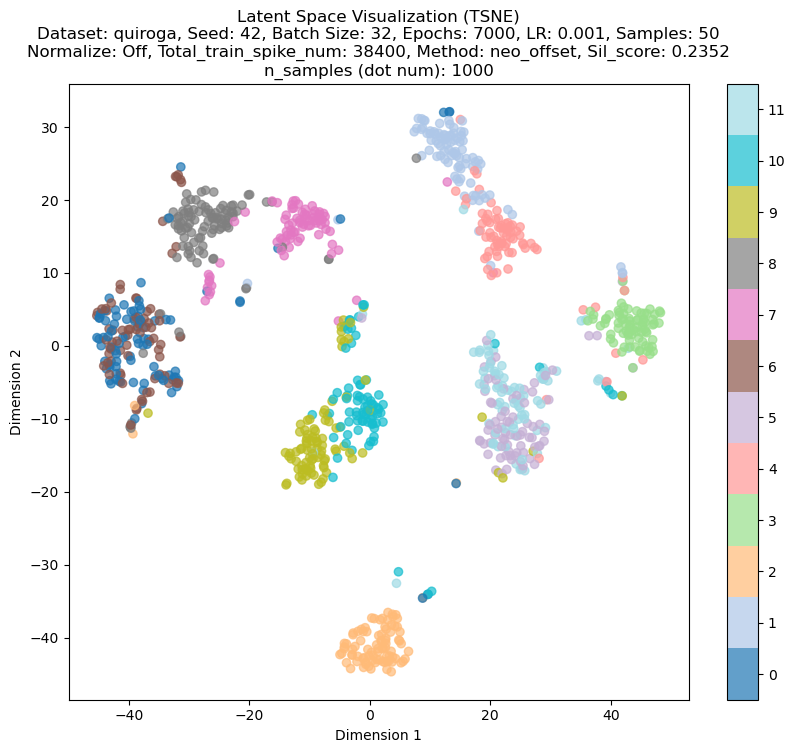

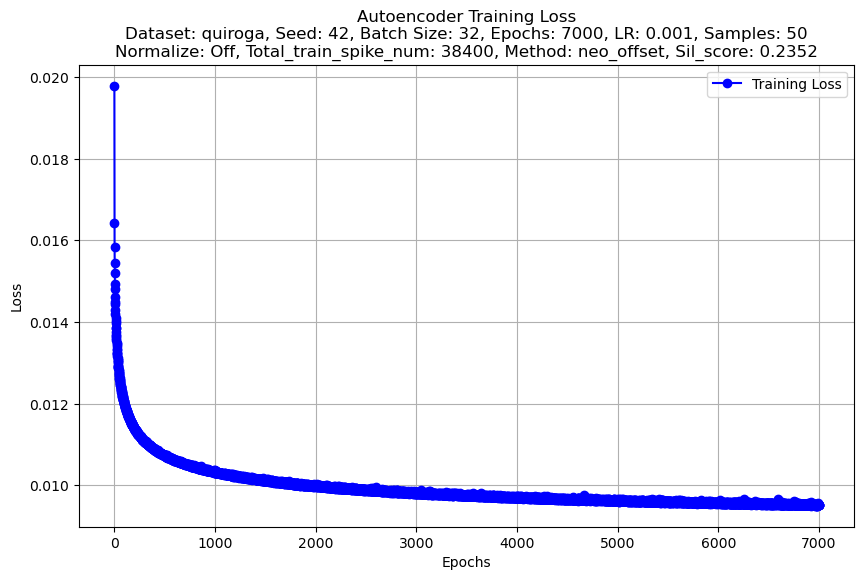

In [ ]:

# 플롯에 필요한 정보 정의
title_info = {
    "what_data": what_data,
    "my_seed": my_seed,
    "batch_size": batch_size,
    "epoch": epoch,
    "learning_rate": learning_rate,
    "n_sample": n_sample,  # Train 데이터 샘플 수
    "normalize_on": "On" if normalize_on else "Off",  # 정규화 상태
    "total_train_spike_num": total_train_spike_num,
    "method": method
}

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def visualize_latent_space(model, data_loader, n_samples=1000, method="PCA"):
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, lbls = data
            inputs, lbls = inputs.to(device), lbls.to(device)
            if 'SAE' in model.module.__class__.__name__:
                inputs = inputs.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
            latent = model.module.encoder(inputs)  # Latent representation 얻기
            latent=latent.reshape(latent.size(0), -1)
            latent_representations.append(latent.cpu().numpy())
            # print('inputs:',inputs.shape, 'lbls:',lbls.shape)
            # print('latent:',latent.shape)

            labels.extend(lbls.cpu().numpy())
            if len(labels) >= n_samples:
                break

    latent_representations = np.concatenate(latent_representations, axis=0)[:n_samples]
    labels = np.array(labels[:n_samples])

    # 차원 축소
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=my_seed)
    else:
        raise ValueError("method must be 'PCA' or 'TSNE'")
    
    reduced_data = reducer.fit_transform(latent_representations)
    # print(len(labels), len(reduced_data))
    # for i in range(len(labels)):
    #     print(f"Label: {labels[i]}, reduced_data: {reduced_data[i]}")
    sil_score = silhouette_score(latent_representations, labels) # 이 값은 -1에서 1까지의 범위를 가지며, 값이 1에 가까울수록 좋습니다.

    # 시각화
    plt.figure(figsize=(10,8))
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)
    # print(f"Number of Classes: {n_classes}, Classes: {unique_classes}")

    cmap = plt.get_cmap("tab20", n_classes) if n_classes > 10 else plt.get_cmap("tab10", n_classes)
    scatter = plt.scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        c=labels,
        cmap=cmap,  # 동적으로 클래스 수에 맞는 cmap 생성
        alpha=0.7
    )
    # plt.colorbar(scatter, ticks=range(n_classes))  # 클래스 개수에 맞는 colorbar 생성

    # Colorbar 설정
    cbar = plt.colorbar(scatter)
    ticks = np.arange(n_classes)*(n_classes-1)/(n_classes) +  (n_classes-1)/(2*n_classes) # 색상의 중심에 위치하도록 tick 값 조정
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(unique_classes)  # 클래스 값으로 tick 레이블 설정
   


    plt.title(
        f"Latent Space Visualization ({method})\n"
        f"Dataset: {title_info['what_data']}, Seed: {title_info['my_seed']}, "
        f"Batch Size: {title_info['batch_size']}, Epochs: {title_info['epoch']}, "
        f"LR: {title_info['learning_rate']}, Samples: {title_info['n_sample']}\n"
        f"Normalize: {title_info['normalize_on']}, "
        f"Total_train_spike_num: {title_info['total_train_spike_num']}, "
        f"Method: {title_info['method']}"
        f", "
        f"Sil_score: {sil_score:.4f}"
        f"\n"
        f"n_samples (dot num): {n_samples}"
        
    )


    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    return sil_score
# Latent Space 시각화 (Train 데이터)
sil_score = visualize_latent_space(model, train_loader, method="TSNE")







# Loss 그래프 그리기
def plot_loss(loss_history, title_info):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', color='blue', label='Training Loss')
    plt.title(
        f"Autoencoder Training Loss\n"
        f"Dataset: {title_info['what_data']}, Seed: {title_info['my_seed']}, "
        f"Batch Size: {title_info['batch_size']}, Epochs: {title_info['epoch']}, "
        f"LR: {title_info['learning_rate']}, Samples: {title_info['n_sample']}\n"
        f"Normalize: {title_info['normalize_on']}, "
        f"Total_train_spike_num: {title_info['total_train_spike_num']}, "
        f"Method: {title_info['method']}"
        f", "
        f"Sil_score: {sil_score:.4f}"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

if what_data == 'n2016':
    what_data = f"{what_data} Set{index + 1}"
if what_data == 'quiroga':
    method = 'grad_offset'



# Loss 그래프 호출
plot_loss(loss_history, title_info)

### conv1d size test

In [ ]:
# import torch
# import torch.nn as nn

# # 입력 데이터 (batch_size=1, in_channels=1, input_length=10)
# x = torch.ones(1, 1, 50)  # 입력 데이터도 1로 설정


# # Conv1d Layer 설정 (bias=False, weight=1로 설정)
# conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False) 
# conv1d.weight.data.fill_(1)  # 가중치 값을 1로 설정
# # out = (in+2*padding-kernel_size)/stride +1 (내림)


# # ConvTranspose1d Layer 설정 (bias=False, weight=1로 설정)
# conv_transpose1d = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, output_padding=1, bias=False)
# conv_transpose1d.weight.data.fill_(1)  # 가중치 값을 1로 설정

# # Conv1d 연산
# conv1d_output = conv1d(x)

# deconv_input= torch.ones_like(conv1d_output)

# # ConvTranspose1d 연산
# conv_transpose1d_output = conv_transpose1d(deconv_input)

# # 입력 데이터 출력
# print("Input:")
# print(x)
# print(x.size())

# # Conv1d 출력
# print("\nConv1d Output:")
# print(conv1d_output)
# print(conv1d_output.size())

# # ConvTranspose1d 출력
# print("\nConvTranspose1d Output:")
# print(conv_transpose1d_output)
# print(conv_transpose1d_output.size())

